<a id='TopPage'></a>
## Initial EDA

#### Contents:

- Imports
    - [Module Imports](#LImports)
    - [Data Import](#DImports)
- [Feature Engineering](#FEngin)
- [Vader Sentiment Analysis](#Vader)
- [Modeling](#Model)
    - [Logistic Regression](#LogReg)
        - [Model](#Model0)
        - [Threshold Manipulation](#Thresh0)
        - [Results](#Res0)
    - [Bagging (Pre Gridsearch)](#BaggingPG)
        - [Model](#Model1)
        - [Threshold Manipulation](#Thresh1)
        - [Results](#Res1)
    - [Gridsearch (Bagging)](#GridsearchB)
        - [Model](#Model2)
        - [Threshold Manipulation](#Thresh2)
        - [Results](#Res2)
    - [Optimised Bagging](#BaggingG)
        - [Model](#Model3)
        - [Threshold Manipulation](#Thresh3)
        - [Results](#Res3)
    


<a id='LImports'></a>
**Module Imports:**

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
sns.set(font_scale=0.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler

import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from maxacc import maxacc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

<a id='DImports'></a>
**Data Imports:**

In [13]:
reddit_data = pd.read_json('Clean_Data')

In [14]:
reddit_data.created_utc = pd.to_datetime(reddit_data.created_utc.map(time.ctime))
reddit_data.retrieved_on = pd.to_datetime(reddit_data.retrieved_on.map(time.ctime))
reddit_data.updated_utc = pd.to_datetime(reddit_data.updated_utc.map(time.ctime))

---

<a id='FEngin'></a>
## Feature Engineering:

In [15]:
# Creating a colums which shows the length of the text
reddit_data['quote_len'] = reddit_data.selftext.map(lambda x: len(x.split()))

In [16]:
# Creating a columns that is 1 if family is mentioned and 0 if not
fam = ['brother','sister','family','mum','mother','dad','father','son','daughter','Son','mom','bro']
reddit_data['family?'] = [bool(sum([1 if i in j else 0 for i in fam]))*1 for j in reddit_data.selftext]

In [17]:
# Creating a column for the hour in the day in which the post was created
reddit_data['hour'] = [str(i.hour) for i in reddit_data.created_utc]

In [19]:
# Dummifying hour data
reddit_data_dummy = pd.get_dummies(reddit_data,columns=['hour'])

In [20]:
reddit_data_dummy = reddit_data_dummy.loc[:,'created_utc':]

In [21]:
reddit_data_dummy.columns

Index(['created_utc', 'gildings', 'is_crosspostable', 'is_robot_indexable',
       'no_follow', 'num_comments', 'over_18', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'updated_utc', 'wls', 'Ass', 'Ass2', 'y',
       'quote_len', 'family?', 'hour_0', 'hour_1', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_2', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9'],
      dtype='object')

---

<a id='Vader'></a>
## Vader Sentiment Analysis (Creating Features):

In [23]:
analyzer = SentimentIntensityAnalyzer()
for sentence in reddit_data.selftext.values:
    vs = analyzer.polarity_scores(sentence)

In [24]:
vader_scores = reddit_data['selftext'].map(analyzer.polarity_scores)

In [25]:
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)
vader_scores

<5693x4 sparse matrix of type '<class 'numpy.float64'>'
	with 22590 stored elements in Compressed Sparse Row format>

In [28]:
for i, col in enumerate(dvec.feature_names_):
    reddit_data_dummy['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

---

<a id='Model'></a>
## Modelling:

<a id='LogReg'></a>
**Logistic Regression:**

<a id='Model0'></a>
Model:

In [223]:
scaler = StandardScaler()

base = pd.Series(reddit_data.y).value_counts(normalize=True)

X = reddit_data_dummy[['gildings', 'is_crosspostable', 'is_robot_indexable',
       'no_follow', 'num_comments', 'over_18', 'score', 'send_replies', 'wls',
       'vader_compound', 'vader_neg', 'vader_neu', 'vader_pos', 'quote_len',
       'family?', 'hour_0', 'hour_1', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_2', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9']].astype(float)
y = reddit_data_dummy.y

Xs = scaler.fit_transform(X)

Xtrain,Xtest,ytrain,ytest = train_test_split(Xs,y,test_size = 0.2,shuffle=True,stratify=y,random_state = 2)

lr = LogisticRegression(solver='lbfgs',class_weight='balanced')
lr.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

<a id='Thresh0'></a>
Threshold Manipulation:

In [224]:
probs = lr.predict_proba(Xtest)
acc=[]
for i in np.linspace(0.3,0.7,num=200):
    yhat = ['NTA' if j[0] > i else 'YTA' for j in probs]
    acc.append(accuracy_score(ytest, yhat))
thresh = np.linspace(0.3,0.7,num=200)[acc.index(max(acc))]
yhat = ['NTA' if j[0] > thresh else 'YTA' for j in probs]
accmax = max(acc)

<a id='Res0'></a>
Results:

In [276]:
lr_coefs = pd.DataFrame(lr.coef_,columns=X.columns).sort_values(0,ascending=False,axis=1)
lr_co2 = lr_coefs.T[np.abs(lr_coefs.T[0])>=0.05].T

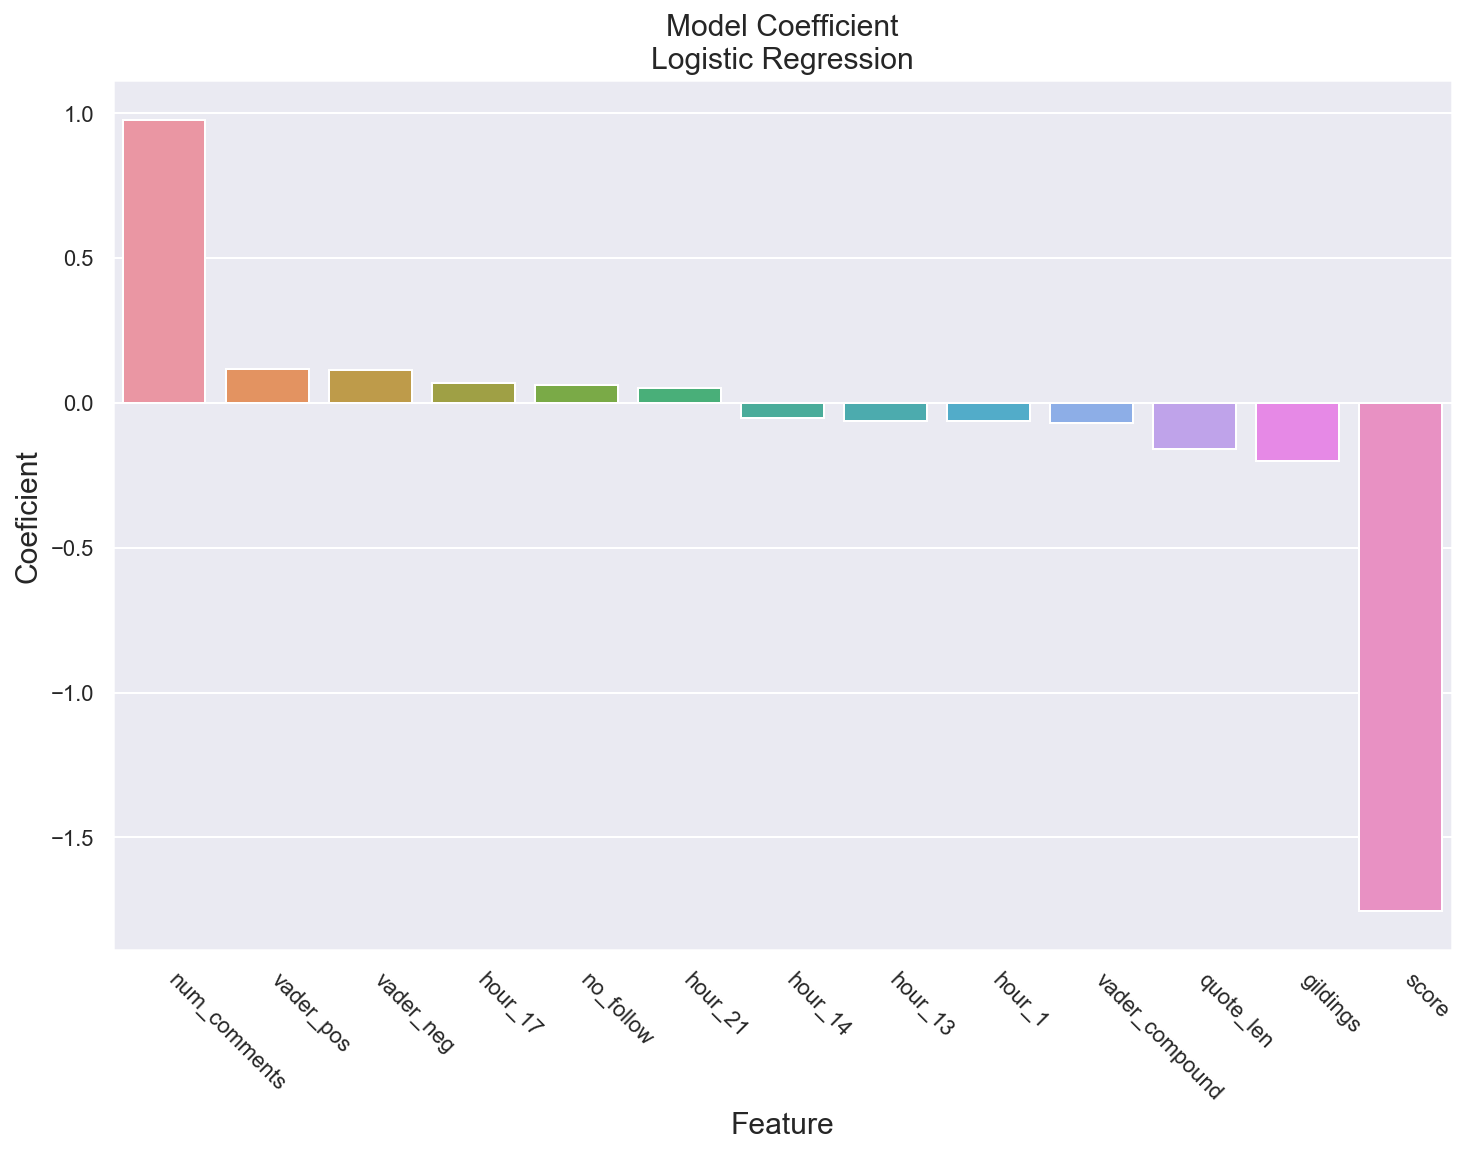

In [289]:
fig,ax = plt.subplots(figsize = [12,8])
sns.barplot(data=lr_co2)
plt.xlabel('Feature',fontdict={'fontsize':15})
plt.ylabel('Coeficient',fontdict={'fontsize':15})
plt.title('Model Coefficient\nLogistic Regression',fontdict={'fontsize':15})
plt.xticks(rotation=-45,ha='left');

In [225]:
print('Confusion Matrix:\n',confusion_matrix(ytest,yhat),'\n')

print('Test Accuracy Scory:',accuracy_score(ytest,yhat))

print('Baseline Score:',base[0],'\n\n')

print('Classification Report:\n',classification_report(ytest,yhat))

Confusion Matrix:
 [[493 159]
 [289 198]] 

Test Accuracy Scory: 0.6066725197541704
Baseline Score: 0.5726330581415774 


Classification Report:
               precision    recall  f1-score   support

         NTA       0.63      0.76      0.69       652
         YTA       0.55      0.41      0.47       487

   micro avg       0.61      0.61      0.61      1139
   macro avg       0.59      0.58      0.58      1139
weighted avg       0.60      0.61      0.59      1139



---

<a id='BaggingPG'></a>
**Bagging (Pre Gridsearch):**

<a id='Model1'></a>
Model:

In [226]:
bc = BaggingClassifier(n_estimators=100,max_samples=100,max_features=5,n_jobs=-1)
bc.fit(Xtrain,ytrain)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=5, max_samples=100,
         n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

<a id='Thresh1'></a>
Threshold Manipulation:

In [227]:
probs = bc.predict_proba(Xtest)
acc=[]
for i in np.linspace(0.3,0.7,num=200):
    yhat = ['NTA' if j[0] > i else 'YTA' for j in probs]
    acc.append(accuracy_score(ytest, yhat))
thresh = np.linspace(0.3,0.7,num=200)[acc.index(max(acc))]
yhat = ['NTA' if j[0] > thresh else 'YTA' for j in probs]
accmax = max(acc)

<a id='Res1'></a>
Results:

In [228]:
print('Confusion Matrix:\n',confusion_matrix(ytest,yhat),'\n')

print('Test Accuracy Scory:',accuracy_score(ytest,yhat))

print('Baseline Score:',base[0],'\n\n')

print('Classification Report:\n',classification_report(ytest,yhat))

Confusion Matrix:
 [[523 129]
 [317 170]] 

Test Accuracy Scory: 0.6084284460052678
Baseline Score: 0.5726330581415774 


Classification Report:
               precision    recall  f1-score   support

         NTA       0.62      0.80      0.70       652
         YTA       0.57      0.35      0.43       487

   micro avg       0.61      0.61      0.61      1139
   macro avg       0.60      0.58      0.57      1139
weighted avg       0.60      0.61      0.59      1139



---

<a id='GridsearchB'></a>
**GridSearch (Bagging):**

<a id='Model2'></a>
Model:

In [229]:
knn = KNeighborsClassifier(n_neighbors=20)
dtc = DecisionTreeClassifier()

In [230]:
params = {'base_estimator':[knn,dtc],
          'n_estimators':[100,200,300,400,500],
          'max_samples':[100], 'max_features':[1,2,3,4,5,6,7,8,9,10],
          'bootstrap':[True], 'bootstrap_features':[True]}

In [204]:
gcv = GridSearchCV(bc,params,cv=5,verbose = 1,n_jobs=-1)
gcv.fit(Xtrain,ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=5, max_samples=100,
         n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'base_estimator': [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features... 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'bootstrap': [True], 'bootstrap_features': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

<a id='Thresh2'></a>
Threshold Manipulation:

In [231]:
probs = gcv.predict_proba(Xtest)
acc=[]
for i in np.linspace(0.3,0.7,num=200):
    yhat = ['NTA' if j[0] > i else 'YTA' for j in probs]
    acc.append(accuracy_score(ytest, yhat))
thresh = np.linspace(0.3,0.7,num=200)[acc.index(max(acc))]
yhat = ['NTA' if j[0] > thresh else 'YTA' for j in probs]
accmax = max(acc)

<a id='Res2'></a>
Results:

In [232]:
print('Confusion Matrix:\n',confusion_matrix(ytest,yhat),'\n')

print('Test Accuracy Scory:',accuracy_score(ytest,yhat))

print('Baseline Score:',base[0],'\n\n')

print('Classification Report:\n',classification_report(ytest,yhat))

Confusion Matrix:
 [[523 129]
 [313 174]] 

Test Accuracy Scory: 0.6119402985074627
Baseline Score: 0.5726330581415774 


Classification Report:
               precision    recall  f1-score   support

         NTA       0.63      0.80      0.70       652
         YTA       0.57      0.36      0.44       487

   micro avg       0.61      0.61      0.61      1139
   macro avg       0.60      0.58      0.57      1139
weighted avg       0.60      0.61      0.59      1139



---

<a id='BaggingG'></a>
**Optimised Bagging:**

<a id='Model3'></a>
Model:

In [233]:
bc = BaggingClassifier(gcv.best_estimator_)
bc.fit(Xtrain,ytrain)

BaggingClassifier(base_estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
       ...estimators=200, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

<a id='Thresh3'></a>
Threshold Manipulation:

In [234]:
probs = bc.predict_proba(Xtest)
acc=[]
for i in np.linspace(0.3,0.7,num=200):
    yhat = ['NTA' if j[0] > i else 'YTA' for j in probs]
    acc.append(accuracy_score(ytest, yhat))
thresh = np.linspace(0.3,0.7,num=200)[acc.index(max(acc))]
yhat = ['NTA' if j[0] > thresh else 'YTA' for j in probs]
accmax = max(acc)

<a id='Res3'></a>
Results:

In [248]:
print('Confusion Matrix:\n',confusion_matrix(ytest,yhat),'\n')

print('Test Accuracy Scory:',accuracy_score(ytest,yhat))

print('Baseline Score:',base[0],'\n\n')

print('Classification Report:\n',classification_report(ytest,yhat))

Confusion Matrix:
 [[538 114]
 [278 209]] 

Test Accuracy Scory: 0.655838454784899
Baseline Score: 0.5726330581415774 


Classification Report:
               precision    recall  f1-score   support

         NTA       0.66      0.83      0.73       652
         YTA       0.65      0.43      0.52       487

   micro avg       0.66      0.66      0.66      1139
   macro avg       0.65      0.63      0.62      1139
weighted avg       0.65      0.66      0.64      1139



In [210]:
reddit_data_dummy.to_json('Vadered_Data')

- [Top of Page](#TopPage)
- [Next Section](./Sub6_Regression_Analysis.ipynb)